In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# HS 데이터 추출

In [2]:
data = pd.read_csv('./211104/211104 kepsh2.csv', parse_dates = True)

In [3]:
data

,datetime,Heatpump_Load(W),BIPV_Supply(W),Pvt_Supply(W),Thermal_Operation_Mode,Room_Temp(�C),CS1(�C),CS2(�C),CS3(�C),CS4(�C),...,CS14(�C),CS15(�C),F1(lpm),F2(lpm),F3(lpm),Valve6(MV6),F4(lpm),Total_Consumption(W),Total_Production(W),F5(lpm)
0,2021-07-03 00:00:00,6.0,-32.0,1.0,164.0,27.6000,26.2617,39.7367,39.2300,38.5150,...,11.7817,26.1067,0.000,0.000,0.000,0.0,0.000,0,0,0.000
1,2021-07-03 00:01:00,6.0,-32.0,1.0,164.0,27.6000,26.2667,39.7367,39.2333,38.5283,...,11.7800,26.1050,0.000,0.000,0.000,0.0,0.000,0,0,0.000
2,2021-07-03 00:02:00,6.0,-32.0,1.0,164.0,27.1322,25.8102,39.0593,38.5712,37.8763,...,11.6034,25.6559,0.000,0.000,0.000,0.0,0.000,0,0,0.000
3,2021-07-03 00:03:00,6.0,-32.0,1.0,164.0,27.6000,26.2400,39.7383,39.2317,38.5250,...,11.8117,26.0933,0.000,0.000,0.000,0.0,0.000,0,0,0.000
4,2021-07-03 00:04:00,258.0,-32.0,1.0,164.0,27.6000,26.2250,39.7400,39.2283,38.5183,...,11.8300,26.0833,0.000,0.000,0.000,0.0,0.000,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158493,2021-11-04 16:27:00,10.0,555.0,67.0,3.0,26.4000,44.4350,46.8320,46.5600,45.4680,...,22.0670,21.6330,0.187,0.001,0.009,0.0,0.010,341,622,0.001
158494,2021-11-04 16:28:00,10.0,542.0,65.0,3.0,26.4000,44.1630,46.8330,46.5600,45.4750,...,22.0580,21.6280,0.190,0.000,0.011,0.0,0.007,421,608,0.000
158495,2021-11-04 16:29:00,10.0,524.0,63.0,3.0,26.4000,43.8630,46.8420,46.5550,45.4730,...,22.0600,21.6220,0.190,0.001,0.011,0.0,0.006,337,587,0.001
158496,2021-11-04 16:30:00,10.0,510.0,62.0,3.0,26.4000,43.5830,46.8320,46.5630,45.4680,...,22.0630,21.6230,0.185,0.001,0.010,0.0,0.006,401,572,0.001


In [4]:
all_features = data.columns.tolist()
print(all_features)

['datetime', 'Heatpump_Load(W)', 'BIPV_Supply(W)', 'Pvt_Supply(W)', 'Thermal_Operation_Mode', 'Room_Temp(�C)', 'CS1(�C)', 'CS2(�C)', 'CS3(�C)', 'CS4(�C)', 'CS5(�C)', 'CS7(�C)', 'CS8(�C)', 'CS9(�C)', 'CS10(�C)', 'CS11(�C)', 'CS12(�C)', 'CS13(�C)', 'CS14(�C)', 'CS15(�C)', 'F1(lpm)', 'F2(lpm)', 'F3(lpm)', 'Valve6(MV6)', 'F4(lpm)', 'Total_Consumption(W)', 'Total_Production(W)', 'F5(lpm)']


In [5]:
df_kepsh2 = pd.DataFrame()
df_kepsh2['Time'] = data['datetime']
# PV, PVT 음수값은 0으로 처리
df_kepsh2['PV_kepsh2(W)'] = np.where(data['BIPV_Supply(W)']<0, 0, data['BIPV_Supply(W)'])
df_kepsh2['PVT_kepsh2(W)'] = np.where(data['Pvt_Supply(W)']<0, 0, data['Pvt_Supply(W)'])
df_kepsh2['HP_kepsh2(W)'] = data['Heatpump_Load(W)']
df_kepsh2['Cons_kepsh2(W)'] = data['Total_Consumption(W)']
df_kepsh2['Prod_kepsh2(W)'] = data['Total_Production(W)']

df_kepsh2.head()


,Time,PV_kepsh2(W),PVT_kepsh2(W),HP_kepsh2(W),Cons_kepsh2(W),Prod_kepsh2(W)
0,2021-07-03 00:00:00,0.0,1.0,6.0,0,0
1,2021-07-03 00:01:00,0.0,1.0,6.0,0,0
2,2021-07-03 00:02:00,0.0,1.0,6.0,0,0
3,2021-07-03 00:03:00,0.0,1.0,6.0,0,0
4,2021-07-03 00:04:00,0.0,1.0,258.0,0,0


In [6]:
df_kepsh2['Time'] = pd.to_datetime(df_kepsh2['Time'])

In [7]:
df_kepsh2 = df_kepsh2[df_kepsh2['Cons_kepsh2(W)']< 10000]

In [8]:
df_kepsh2 = df_kepsh2[(df_kepsh2['Time']>='2021-09-13 00:00:00') ]
df_kepsh2 = df_kepsh2[(df_kepsh2['Time']<='2021-11-03 23:59:00') ]

In [9]:
df_kepsh2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65315 entries, 92191 to 157505
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Time            65315 non-null  datetime64[ns]
 1   PV_kepsh2(W)    65314 non-null  float64       
 2   PVT_kepsh2(W)   65314 non-null  float64       
 3   HP_kepsh2(W)    65314 non-null  float64       
 4   Cons_kepsh2(W)  65315 non-null  int64         
 5   Prod_kepsh2(W)  65315 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 3.5 MB


In [10]:
df_kepsh2['Cons_kepsh2(W)'] = df_kepsh2['Cons_kepsh2(W)'].astype(float)
df_kepsh2['Prod_kepsh2(W)'] = df_kepsh2['Prod_kepsh2(W)'].astype(float)

In [11]:
df_kepsh2['Cons_acc_kepsh2(Wh)'] = df_kepsh2['Cons_kepsh2(W)'].cumsum()*60/3600
df_kepsh2['Prod_acc_kepsh2(Wh)'] = df_kepsh2['Prod_kepsh2(W)'].cumsum()*60/3600

In [12]:
df_kepsh2['PV_acc_kepsh2(Wh)'] = df_kepsh2['PV_kepsh2(W)'].cumsum()*60/3600
df_kepsh2['PVT_acc_kepsh2(Wh)'] = df_kepsh2['PVT_kepsh2(W)'].cumsum()*60/3600

In [13]:
df_kepsh2['denominator'] = df_kepsh2.loc[:,['Cons_kepsh2(W)','Prod_kepsh2(W)']].min(axis=1)
df_kepsh2['denominator_acc'] = df_kepsh2.loc[:,['Cons_acc_kepsh2(Wh)','Prod_acc_kepsh2(Wh)']].min(axis=1)

In [14]:
df_kepsh2['SCF'] = df_kepsh2['denominator']/df_kepsh2['Prod_kepsh2(W)']
df_kepsh2['LCF'] = df_kepsh2['denominator']/df_kepsh2['Cons_kepsh2(W)']

In [15]:
df_kepsh2['SCF_acc'] = df_kepsh2['denominator_acc']/df_kepsh2['Prod_acc_kepsh2(Wh)']
df_kepsh2['LCF_acc'] = df_kepsh2['denominator_acc']/df_kepsh2['Cons_acc_kepsh2(Wh)']
df_kepsh2['self_sustain'] = df_kepsh2['Prod_acc_kepsh2(Wh)']/df_kepsh2['Cons_acc_kepsh2(Wh)']
df_kepsh2['Avg_SCF&LCF'] = (df_kepsh2['SCF_acc']+df_kepsh2['LCF_acc'])/2

In [16]:
df_kepsh2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65315 entries, 92191 to 157505
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Time                 65315 non-null  datetime64[ns]
 1   PV_kepsh2(W)         65314 non-null  float64       
 2   PVT_kepsh2(W)        65314 non-null  float64       
 3   HP_kepsh2(W)         65314 non-null  float64       
 4   Cons_kepsh2(W)       65315 non-null  float64       
 5   Prod_kepsh2(W)       65315 non-null  float64       
 6   Cons_acc_kepsh2(Wh)  65315 non-null  float64       
 7   Prod_acc_kepsh2(Wh)  65315 non-null  float64       
 8   PV_acc_kepsh2(Wh)    65314 non-null  float64       
 9   PVT_acc_kepsh2(Wh)   65314 non-null  float64       
 10  denominator          65315 non-null  float64       
 11  denominator_acc      65315 non-null  float64       
 12  SCF                  40874 non-null  float64       
 13  LCF                  65309

In [17]:
df_kepsh2

,Time,PV_kepsh2(W),PVT_kepsh2(W),HP_kepsh2(W),Cons_kepsh2(W),Prod_kepsh2(W),Cons_acc_kepsh2(Wh),Prod_acc_kepsh2(Wh),PV_acc_kepsh2(Wh),PVT_acc_kepsh2(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
92191,2021-09-13 00:00:00,0.0,1.0,6.0,299.0,1.0,4.983333e+00,1.666667e-02,0.000000e+00,0.016667,1.0,1.666667e-02,1.0,0.003344,1.000000,0.003344,0.003344,0.501672
92192,2021-09-13 00:03:00,0.0,1.0,5.0,190.0,1.0,8.150000e+00,3.333333e-02,0.000000e+00,0.033333,1.0,3.333333e-02,1.0,0.005263,1.000000,0.004090,0.004090,0.502045
92193,2021-09-13 00:06:00,0.0,1.0,5.0,188.0,1.0,1.128333e+01,5.000000e-02,0.000000e+00,0.050000,1.0,5.000000e-02,1.0,0.005319,1.000000,0.004431,0.004431,0.502216
92194,2021-09-13 00:07:00,0.0,1.0,6.0,198.0,1.0,1.458333e+01,6.666667e-02,0.000000e+00,0.066667,1.0,6.666667e-02,1.0,0.005051,1.000000,0.004571,0.004571,0.502286
92195,2021-09-13 00:08:00,0.0,1.0,6.0,204.0,1.0,1.798333e+01,8.333333e-02,0.000000e+00,0.083333,1.0,8.333333e-02,1.0,0.004902,1.000000,0.004634,0.004634,0.502317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157501,2021-11-03 23:55:00,0.0,0.0,10.0,371.0,0.0,1.005112e+06,1.511982e+06,1.456512e+06,55462.700000,0.0,1.005112e+06,NaN,0.000000,0.664765,1.000000,1.504292,0.832382
157502,2021-11-03 23:56:00,0.0,0.0,10.0,411.0,0.0,1.005119e+06,1.511982e+06,1.456512e+06,55462.700000,0.0,1.005119e+06,NaN,0.000000,0.664769,1.000000,1.504282,0.832385
157503,2021-11-03 23:57:00,0.0,0.0,10.0,359.0,0.0,1.005125e+06,1.511982e+06,1.456512e+06,55462.700000,0.0,1.005125e+06,NaN,0.000000,0.664773,1.000000,1.504273,0.832387
157504,2021-11-03 23:58:00,0.0,0.0,10.0,393.0,0.0,1.005131e+06,1.511982e+06,1.456512e+06,55462.700000,0.0,1.005131e+06,NaN,0.000000,0.664777,1.000000,1.504263,0.832389


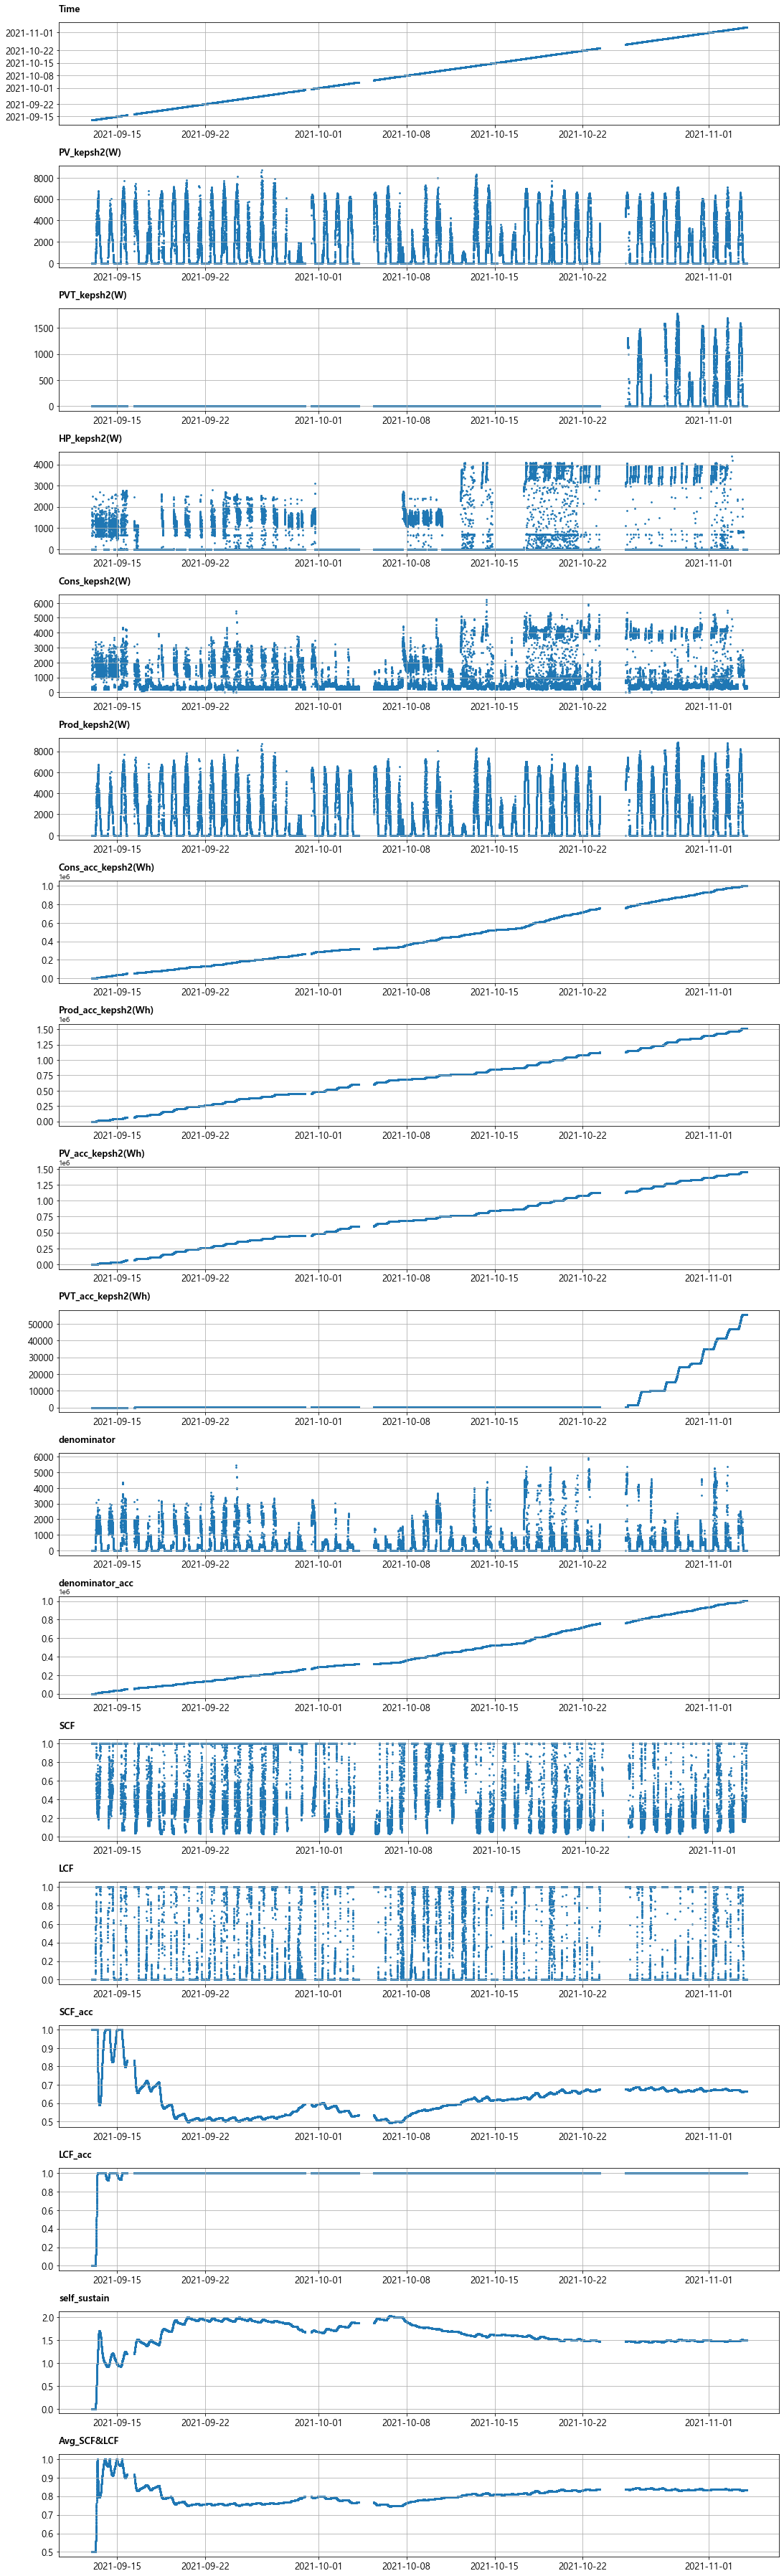

In [18]:
fig, ax = plt.subplots(figsize=(18,65))


for i in range(len(df_kepsh2.columns)):
    plt.subplot(len(df_kepsh2.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
#     plt.xlim(pd.Timestamp('2021-04-01'), pd.Timestamp('2021-11-30'))
    name = df_kepsh2.columns[i]
    plt.scatter(x=df_kepsh2['Time'], y=df_kepsh2[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()

# Line graph

In [19]:
df_kepsh2 = df_kepsh2.set_index('Time')

In [20]:
df_kepsh2.to_csv('./211109_kepsh2.csv')

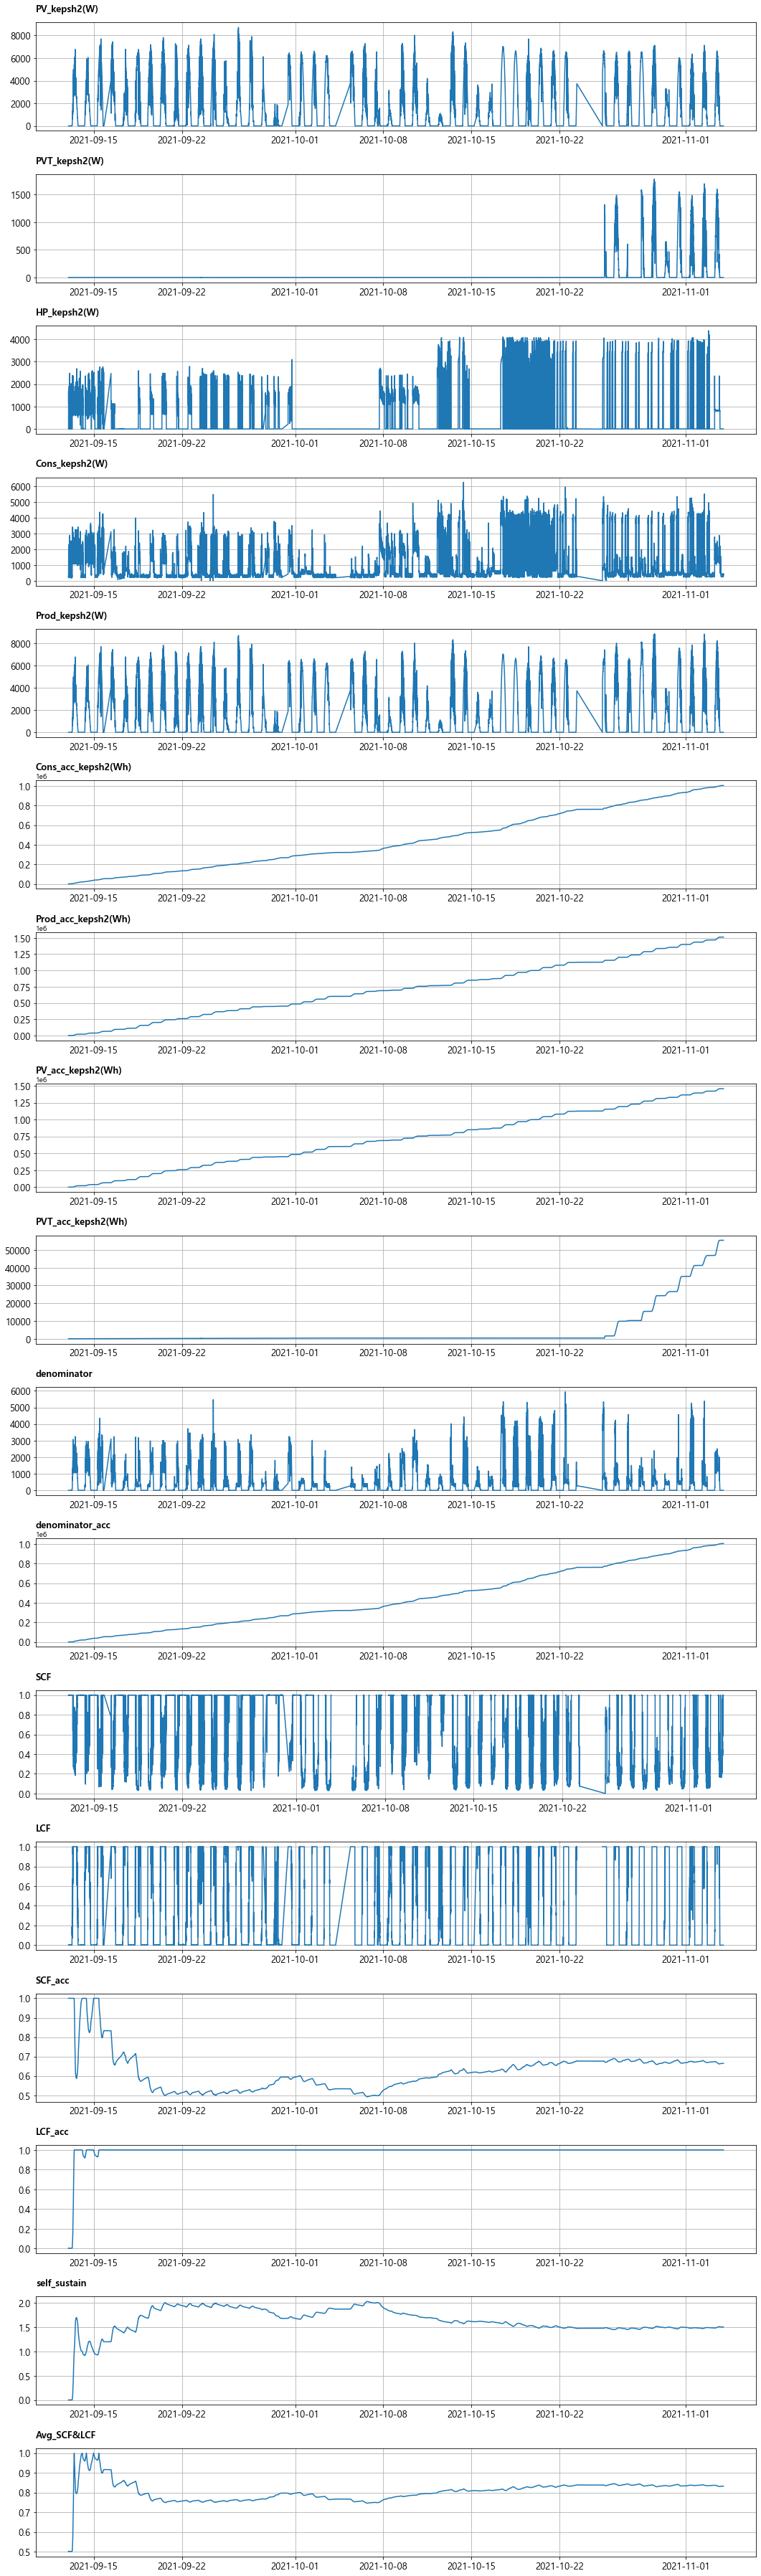

In [21]:
fig, ax = plt.subplots(figsize=(18,65))

for i in range(len(df_kepsh2.columns)):
    plt.subplot(len(df_kepsh2.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kepsh2.columns[i]
    plt.plot(df_kepsh2[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
#     plt.xlim(pd.Timestamp('2021-09-10'), pd.Timestamp('2021-11-05'))    
    plt.grid(True)
plt.show()
fig.tight_layout()